<a href="https://colab.research.google.com/github/kazukitaninaka/taninaka-dsma-final/blob/main/DSMA_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Read csv file
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid_2021_1.csv")
print(df)

In [4]:
# Read lexicon dictionary
with open("/content/drive/MyDrive/Colab Notebooks/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r") as f:
  lexicontext = f.readlines()
wordline = []
for line in lexicontext:
  wordline.append(line.split("\t"))

In [5]:
def preprocess(sentence):
  # Removing emojis
  sentence = sentence.encode('ascii', 'ignore').decode('ascii')
  # Tokenization
  tokens = word_tokenize(sentence)
  # stopwords removal
  stopWords = set(stopwords.words('english'))
  filteredTokens = [w.lower() for w in tokens if not w.lower() in stopWords]
  # Lemmatization
  wnl = nltk.WordNetLemmatizer()
  lemmalist = [wnl.lemmatize(t) for t in filteredTokens]
  return lemmalist

**Trying to find out what kind of emotion do people have when watching COVID-19 related videos**

In [6]:
# Split words of lexicon dictionary into emoWords depending on the emotion the word is associated with
emoList = ["joy", "trust", "fear", "surprise", "sadness", "disgust", "anger", "anticipation"]
emoWords = [[],[],[],[],[],[],[],[]]
for entry in wordline:
  for emotion in emoList:
    if entry[1] == emotion and int(entry[2][0]) > 0:
      emoWords[emoList.index(emotion)].append(entry[0])

In [7]:
preprocessedWords = []
# preprocess each comment and put it together in a list
for _, row in df.iterrows():
  preprocessedWords += preprocess(row["comment_text"])

In [8]:
# Increament score corresponding to emotion
# It takes a while, please bear
score = [0,0,0,0,0,0,0,0]
for word in preprocessedWords:
  for i in range(len(emoWords)):
    if word in emoWords[i]:
      score[i] += 1
print(score)

[18066, 30029, 22059, 10320, 15849, 10845, 13353, 22575]

In [9]:
# show polar plot
import plotly.express as px
emoDf = pd.DataFrame(dict(
    r=score,
    theta=emoList))
fig = px.line_polar(emoDf, r='r', theta='theta', line_close=True)
fig.show()

**Making a machine learning model to predict if people think a video is trustworthy**

In [10]:
# Group by "title", and put all comments in each video together in a cell
groupedByTitleDf =df.groupby(["title", "views", "likes", "dislikes"], as_index=False)["comment_text"].apply(lambda x: " ".join(x))

In [11]:
# preprocess title and put them in a list
groupedByTitleDf["title_list"] = groupedByTitleDf.apply(lambda row: preprocess(row["title"]), axis=1)
# preprocess comment_text and put them in a list
groupedByTitleDf["comment_list"] = groupedByTitleDf.apply(lambda row: preprocess(row["comment_text"]) , axis=1)

In [12]:
def calcEmoScore(li, emotion=None):
  if emotion == None:
    words = set([entry[0] for entry in wordline if int(entry[2][0]) > 0])
  else:
    words = set([entry[0] for entry in wordline if entry[1] == emotion and int(entry[2][0]) > 0])
  score = 0
  for word in li:
    if word in words:
      score += 1
  return score

In [13]:
groupedByTitleDf["commentTrustScore"] = groupedByTitleDf.apply(lambda row: calcEmoScore(row["comment_list"], "trust"), axis=1)

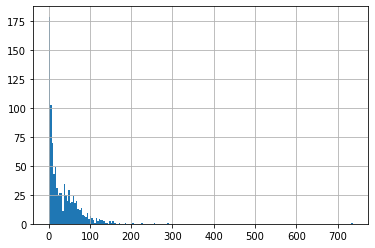

In [14]:
# show histogram of commentTrustScore
groupedByTitleDf["commentTrustScore"].hist(bins=200)

In [15]:
# calc number of each emotional word in title
groupedByTitleDf["titleEmoScore"] = groupedByTitleDf.apply(lambda row: calcEmoScore(row["title_list"]), axis=1)
for emo in ["joy", "trust", "fear", "surprise", "sadness", "disgust", "anger", "anticipation"]:
  groupedByTitleDf[f"title{emo.capitalize()}Score"] = groupedByTitleDf.apply(lambda row: calcEmoScore(row["title_list"], emo), axis=1)

In [16]:
groupedByTitleDf["isTrustworthy"] = groupedByTitleDf["commentTrustScore"] > groupedByTitleDf["commentTrustScore"].mean()
print(groupedByTitleDf)

In [17]:
# removing irrelavant columns
groupedByTitleDf = groupedByTitleDf.drop(["title_list", "comment_list", "comment_text", "commentTrustScore","views", "likes", "dislikes"], axis=1)

In [18]:
X = groupedByTitleDf.drop("isTrustworthy", axis=1)
X = pd.get_dummies(X)
y = groupedByTitleDf["isTrustworthy"]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [21]:
# I got this function from kaggle tutorial "Twitter Sentiment Analysis for Beginners 🔥"
# https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [22]:
y_train.shape

(760,)

In [23]:
X_train.shape

(760, 901)

              precision    recall  f1-score   support

       False       0.72      0.93      0.81        95
        True       0.46      0.15      0.23        40

    accuracy                           0.70       135
   macro avg       0.59      0.54      0.52       135
weighted avg       0.64      0.70      0.64       135



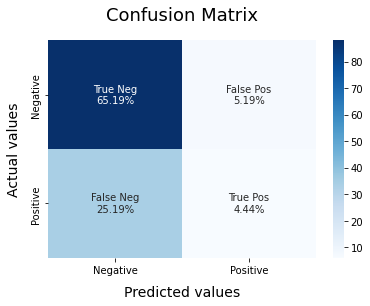

In [24]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

       False       0.70      1.00      0.83        95
        True       0.00      0.00      0.00        40

    accuracy                           0.70       135
   macro avg       0.35      0.50      0.41       135
weighted avg       0.50      0.70      0.58       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



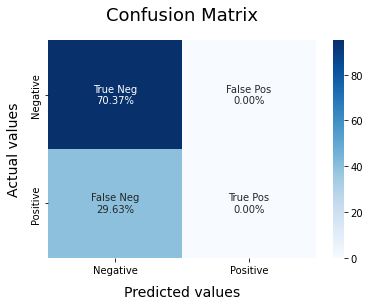

In [25]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)